# Libraries

In [1]:
# import json file called config
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']
nrows = None if config['nrows'] == 0 else config['nrows']
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split # to separate the dataset.
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertModel
import ast

# Data access

In [2]:
data=pd.read_csv('x_y_dataset.csv',nrows=nrows)
X = data['X']
y = data['y']

# Convert the string representation of the list into a list of integers
X = X.apply(lambda x: ast.literal_eval(x))

# Convert the list of lists into a numpy array
X = np.array(X.tolist())
y = data['y']

X
# X is a dataframe with the data of the form : [101, 2202, 2117, 6221, 8398, 270...] transform it into numpy array
y = np.array(y)

# Data split

In [3]:
# we separate the trdata into training test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [4]:
X_train = np.array(X_train.tolist())
y_train= np.array(y_train.tolist())
X_train.shape,y_train.shape

((33276, 512), (33276,))

In [5]:
X_test = np.array(X_test.tolist())
y_test= np.array(y_test.tolist())
X_test.shape,y_test.shape

((4159, 512), (4159,))

In [6]:
X_validation = np.array(X_validation.tolist())
y_validation= np.array(y_validation.tolist())
X_validation.shape,y_validation.shape

((4160, 512), (4160,))

# model naive bayes

In [7]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
Accuracy = NB.score(X_test, y_test)
print("Accuracy Test Data: "+str(round(Accuracy*100,2))+"%")

Accuracy Test Data: 59.61%


In [8]:
y_pred_validation=NB.predict(X_validation)

# we calculate the accuracy of the model on the validation data
accuracy_validation=accuracy_score(y_validation, y_pred_validation)
print("Accuracy Validation Data: " + str(round(accuracy_validation*100)) + "%")


Accuracy Validation Data: 59%


# Model optimization
Nous mettons en place un algorithme de recherche sur grille, ce qui nous permet de trouver les meilleurs hyperparamètres pour le modèle. Nous commençons avec param_grid comportant plusieurs paramètres à tester. 

Le paramètre le plus important est `alpha`, qui est le paramètre de lissage pour le modèle. Il est utilisé pour gérer les données non vues ; plus le `alpha` est élevé, plus le lissage est important. 

En termes simples, cela signifie que le modèle sera moins sensible aux données d'entraînement.

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# On definit les parametres a tester
params_grid={'alpha': [0.01,0.05,0.1,0.5,1,5, 10,50,100,1000]}

# On definit le modele
model = MultinomialNB()

# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver le meilleur C.
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=params_grid, # parametres à tester
    scoring=scorer, # scorer
    cv=5, # cv=5 pour utiliser la validation croisée à 5 folds 
    verbose=2, # verbose=2 pour afficher les logs
    n_jobs=-1, # n_jobs=-1 pour utiliser tous les coeurs du CPU
    return_train_score=True # pour afficher les scores d'entrainement
    )

# On lance les multiples entrainements.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100,
                                   1000]},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'),
             verbose=2)

In [10]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")


Best parameters: {'alpha': 0.01}
Best score: 0.5966763982401896


# Model Evaluation
on evalue les performances de notre model.

In [11]:
# On recupere le meilleur modele
best_model = grid_search.best_estimator_

In [12]:
#lancemenet de l'enrestristrement de la mémoire.
import psutil
import time
import os
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(X_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

Temps d'entrainement (h | m | s) : 0 | 0 | 0
Utilisation de la mémoire (Mo) : 0.0078125


In [13]:
# On predit les donnees de test
y_pred_test = best_model.predict(X_test)

In [14]:
# On calcule l'accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Test Data: {round(accuracy_test*100,2)}%")

Accuracy Test Data: 59.61%


In [15]:
# On predit les donnees de validation
y_pred_validation = best_model.predict(X_validation)
# On calcule l'accuracy
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Accuracy Validation Data: {round(accuracy_validation*100,2)}%")

Accuracy Validation Data: 59.18%


In [16]:
# on test toute les autres metric possible pour évaluer notre model de naive bayes.
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# on fait le classification_report
print(classification_report(y_validation, y_pred_validation))
#on obtient la precision,recall et f1_score
precision = precision_score(y_validation, y_pred_validation)
recall = recall_score(y_validation, y_pred_validation)
f1score = f1_score(y_validation, y_pred_validation)

print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")
print(f"notre model a un recall de {round(recall*100,2)}% . notre model a pu détecter {round(recall*100,2)}% des vrais positifs.")

if f1score<0.5:
    print(f"notre model a un f1 score de {round(f1score*100,2)}% . Ce qui est une performance moyenne.")
else:
    print(f"notre model a un f1 score de {round(f1score*100,2)}% . Ce qui est une bonne performance.")

              precision    recall  f1-score   support

           0       0.61      0.56      0.58      2133
           1       0.57      0.63      0.60      2027

    accuracy                           0.59      4160
   macro avg       0.59      0.59      0.59      4160
weighted avg       0.59      0.59      0.59      4160

notre model a une precision de 57.45% . lorsqu'il prédit une classe comme positive, il a raison dans 57.45% des cas.
notre model a un recall de 62.6% . notre model a pu détecter 62.6% des vrais positifs.
notre model a un f1 score de 59.92% . Ce qui est une bonne performance.


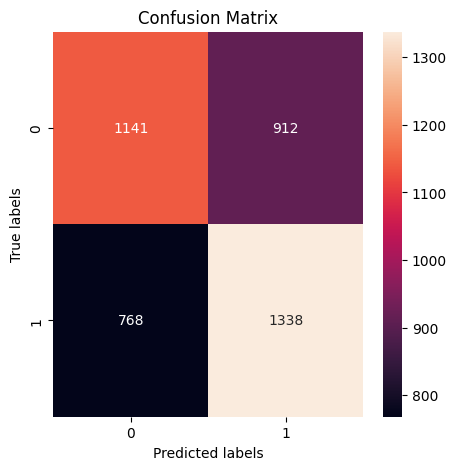

In [17]:
# On affiche la matrice de confusion en utilisant matplotlib
cm=confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 27.43%
False Positive: 21.93%
False Negative: 18.47%
True Positive: 32.17%


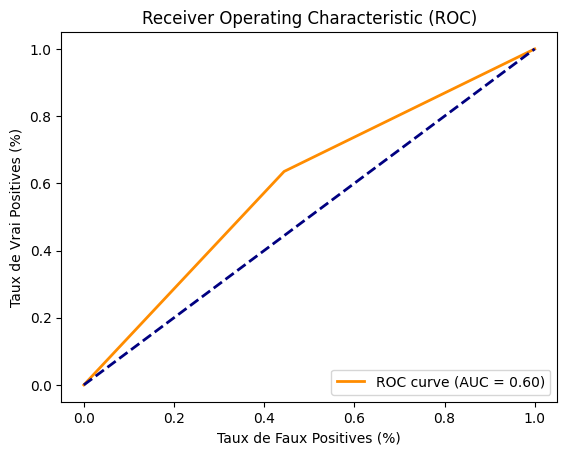

notre model a un roc_auc de 59.55% . Cela signifie que notre modèle a une capacité de 59.55% à distinguer les classes positives et négatives.


In [19]:
# On affiche la courbe ROC
from sklearn.metrics import roc_curve, roc_auc_score
#on obtient y_pred 
#on obtient la valeur roc_auc
roc_auc = roc_auc_score(y_test, y_pred_test)

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
print(f"notre model a un roc_auc de {round(roc_auc*100,2)}% . Cela signifie que notre modèle a une capacité de {round(roc_auc*100,2)}% à distinguer les classes positives et négatives.")

# Test de performances sur des données générées par Téléchargé ailleurs

In [20]:
# Prepare the data
validation_data=pd.read_csv("data/valid_clean.csv",nrows=nrows)
#remove nan values
validation_data=validation_data.dropna()
validation_data=validation_data[['text_processed','isFake']]
validation_data.head()

validation_data_X = validation_data['text_processed']
validation_data_y = validation_data['isFake'].astype(int)

#load the bert_tockenizer.pickle into a variable called tokenizer
import pickle as pkl
with open('bert_tokenizer.pickle', 'rb') as f:
    tokenizer = pkl.load(f)

# Tokenize the data using the BERT tokenizer
encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='np')

# Get the input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(input_ids)


In [21]:
#we print the accuracy of the model
accuracy = accuracy_score(validation_data_y, predictions)
print(f"Accuracy different Dataset: {round(accuracy*100,2)}%")

Accuracy different Dataset: 40.77%


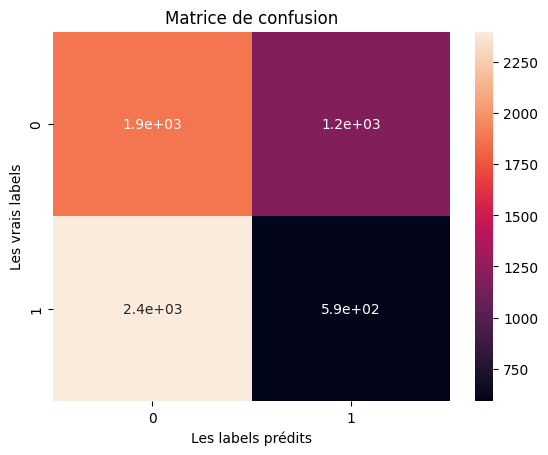

In [22]:
cm = confusion_matrix(validation_data_y,predictions)
#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [23]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 31.02%
False Positive: 19.64%
False Negative: 39.58%
True Positive: 9.76%


# Conclusion

Le modèle présente des performances modérées sur les données de test et de validation avec une précision autour de 59%, et un score F1 de 59.92%, ce qui indique une efficacité raisonnable pour équilibrer la précision et le recall dans les prédictions. Le rappel de 62.6% montre que le modèle est relativement compétent pour identifier les vrais positifs, bien que la capacité de distinguer correctement entre les classes positives et négatives, illustrée par un score ROC-AUC de 59.55%, nous conforte à la conclusion qu'il est encore en train de deviner les classes.

Cette hypothèse est confirmé par un jeu de données différent, la performance du modèle chute significativement, avec une précision de seulement 40.77%. Cette baisse importante souligne des problèmes de généralisation, ce qui suggère que le modèle est potentiellement surajusté aux données de formation ou manque de robustesse face à de nouvelles données.

Pour améliorer la fiabilité et l'efficacité du modèle, nous devons ajustemer des hyperparamètres, une amélioration du traitement des données ou d'essayer des techniques de régularisation plus strictes pour augmenter sa capacité à généraliser sur des données non vues.